In [1]:
import sys , json, glob, random, re, math
import collections, time, zipfile, cv2
from types import SimpleNamespace

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

2024-04-04 06:56:22.551905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 06:56:22.552048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 06:56:22.736707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Configuration Setup**

In [70]:
dir_conf = SimpleNamespace(
    data_directory = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification',
    train_dir = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train',
    test_dir = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test',
)


train_conf = SimpleNamespace(
    IMAGE_SIZE = 128,
    DEPTH_CHANENLS = 64
)

In [78]:
def load_dicom_image(path, img_size=train_conf.IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, dept_chnls=train_conf.DEPTH_CHANENLS, img_size=train_conf.IMAGE_SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{dir_conf.data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    
    print(f"Files length: {len(files)}")
    middle = len(files)//2
    num_imgs2 = dept_chnls//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[0:dept_chnls]]).T 
    if img3d.shape[-1] < dept_chnls:
        n_zero = np.zeros((img_size, img_size, dept_chnls - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return img3d

In [ ]:
def draw_pictures():
    fig ,axs = plt.subplots(4,4, figsize=(32,32))
    for i in range(4):
        for j in range(4):
            ax = axs[i, j]
            ax.imshow(image[:, :, i*j], cmap="gray")
            ax.axis("off")

    plt.tight_layout()

Files length: 129
(128, 128, 64)
0.0 1.0 0.16 0.0
Dimension of the CT scan is: (128, 128, 64)


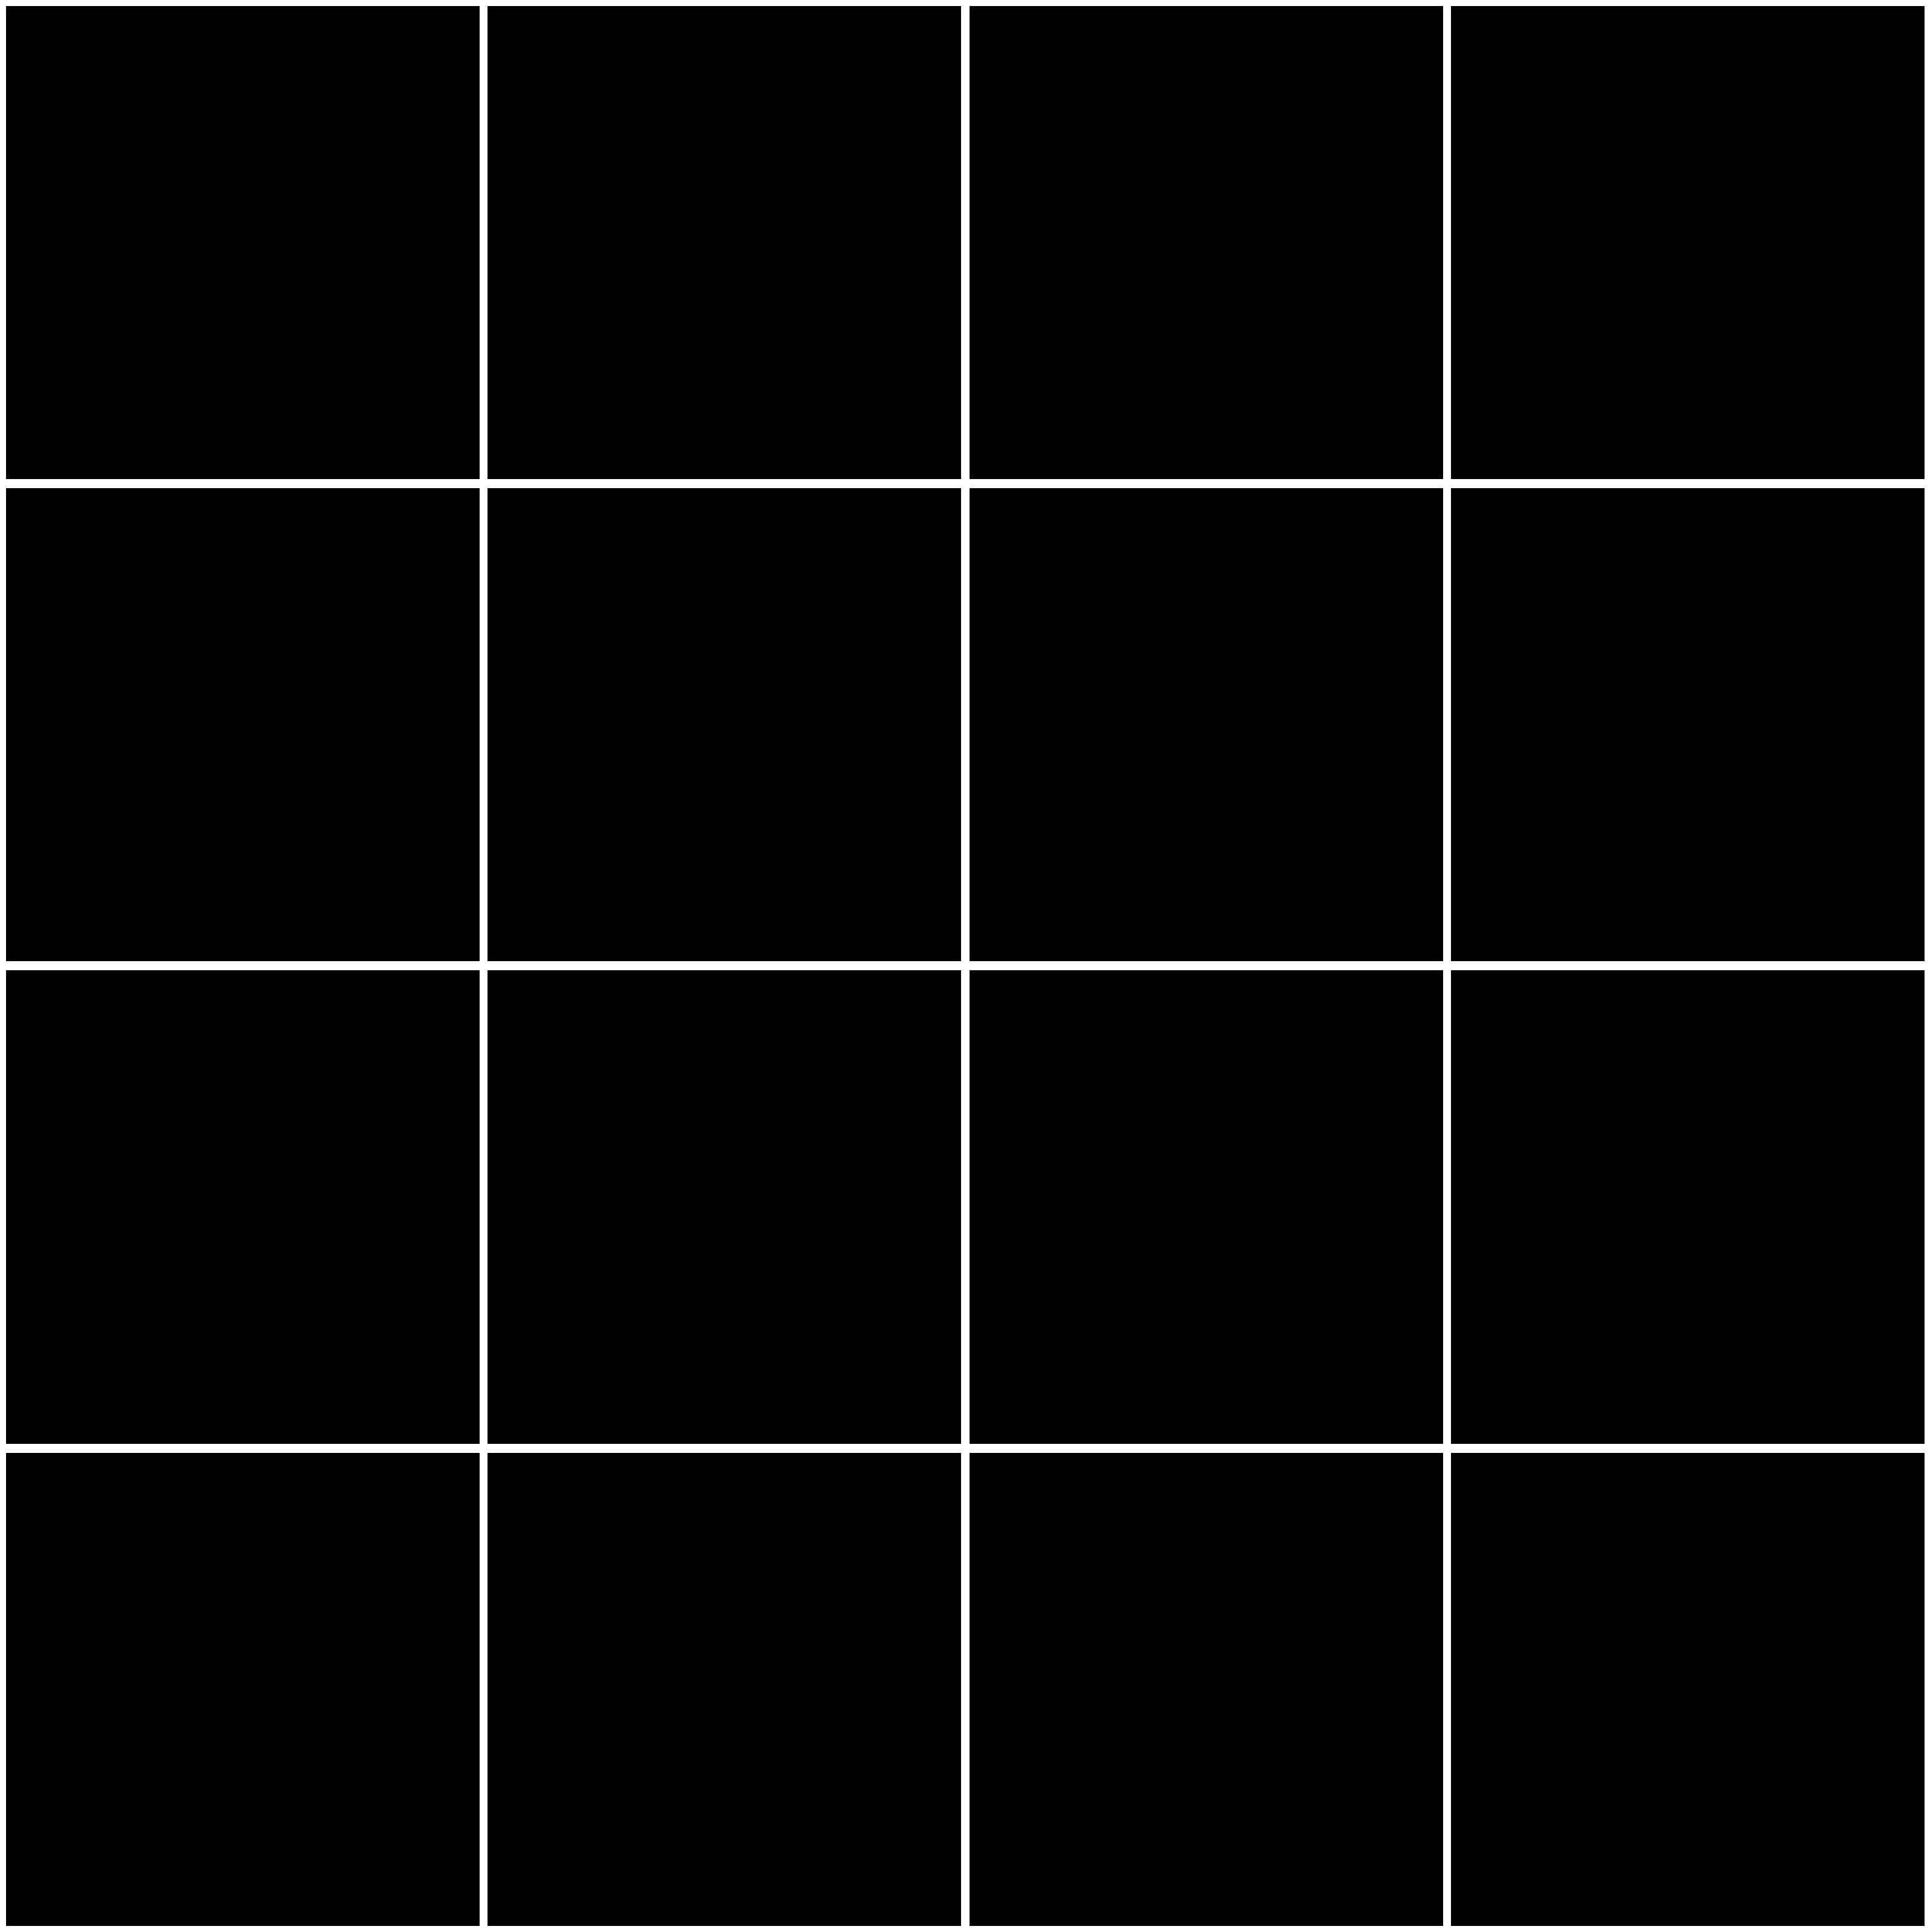

In [79]:
image = load_dicom_images_3d("00003")
print(image.shape)
print(np.min(image), np.max(image), round(np.mean(image), 2), round(np.median(image), 2))
print("Dimension of the CT scan is:", image.shape)


